In [1]:
from __future__ import print_function

import os
import numpy as np
# import torch
# import pandas as pd
from io import StringIO
# from google.cloud import storage
import matplotlib.pyplot as plt#, mpld3
from sklearn import ensemble
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline
# os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="../ab2.json"

In [2]:
def load_data_file(data_file, num_features):
    
    data = np.load(data_file)
    
    if data.ndim == 1:
        data = data[None, :]
    
    x = data[:, :num_features]
    y = data[:, num_features:]
    
    return x, y

In [3]:
num_features = 13
x_data, y_data = load_data_file(data_file='../train/training_hela.npy', num_features=num_features)

In [4]:
Ntr = 70000
x_data_tr = x_data[:Ntr,:]
y_data_tr = y_data[:Ntr,:]
x_data_val = x_data[Ntr:,:]
y_data_val = y_data[Ntr:,:]

https://github.com/exoclime/HELA/blob/ffe2f0e17c86c8b593eaec4a050ec610865e36d1/example_dataset/example_dataset.json

In [5]:
class Model:
    
    def __init__(self, num_trees, num_jobs,ranges, verbose=1):
        scaler = MinMaxScaler(feature_range=(0, 100))
        rf = ensemble.RandomForestRegressor(n_estimators=num_trees,
                                            oob_score=True,
                                            verbose=verbose,
                                            n_jobs=num_jobs,
                                            max_features="sqrt",
                                            min_impurity_decrease=0.01)
        self.scaler = scaler
        self.rf = rf
        self.num_trees = num_trees
        self.num_jobs = num_jobs
        self.verbose = verbose
        self.ranges = ranges
    
    def _scaler_fit(self, y):
        if y.ndim == 1:
            y = y[:, None]
        
        self.scaler.fit(y)
    
    def _scaler_transform(self, y):
        if y.ndim == 1:
            y = y[:, None]
            return self.scaler.transform(y)[:, 0]
        
        return self.scaler.transform(y)
    
    def _scaler_inverse_transform(self, y):
        
        if y.ndim == 1:
            y = y[:, None]
            return self.scaler.inverse_transform(y)[:, 0]
        
        return self.scaler.inverse_transform(y)
    
    def fit(self, x, y):
        self._scaler_fit(y)
        self.rf.fit(x, self._scaler_transform(y))
    
    def predict(self, x):
        pred = self.rf.predict(x)
        return self._scaler_inverse_transform(pred)
    
#     def get_params(self, deep=True):
#         return {"num_trees": self.num_trees, "num_jobs": self.num_jobs,
#                 "names": self.names, "ranges": self.ranges,
#                 "colors": self.colors,
#                 "verbose": self.verbose}
    
    def trees_predict(self, x):
        
        if x.ndim > 1:
            raise ValueError("x.ndim must be 1")
        
        preds = np.array([i.predict(x[None, :])[0] for i in self.rf.estimators_])
        return self._scaler_inverse_transform(preds)

In [9]:
names =  ["T (K)", "H2O", "HCN", "NH3", "kappa0"]
ranges =  [[0, 3000], [-13, 0], [-13, 0], [-13, 0], [-13, 0]],
colors  = ["#F14532", "#4a98c9", "#f4701b", "#4bb062", "#6363d8"],

In [24]:
num_trees=1000

In [12]:
def train_model(training_x, training_y, num_trees=1000, num_jobs=5, verbose=1):
#     pipeline = Model(num_trees, num_jobs,
#                         names=names,
#                         ranges=ranges,
#                         colors=colors,
#                         verbose=verbose)
    pipeline = Model(num_trees, num_jobs,
                    ranges=[[0, 1],[0, 1],[0, 1],[0, 1],[0, 1],[0, 1],[0, 1],[0, 1],[0, 1],[0, 1],[0, 1],[0, 1]],
                    verbose=verbose)
    pipeline.fit(training_x, training_y)
    return pipeline


def test_model(model, dataset, output_path):
    
    if dataset.testing_x is None:
        return
    
    logger.info("Testing model...")
    pred = model.predict(dataset.testing_x)
    r2scores = {name_i: metrics.r2_score(real_i, pred_i)
                    for name_i, real_i, pred_i in zip(dataset.names, dataset.testing_y.T, pred.T)}
    print("Testing scores:")
    for name, values in r2scores.items():
        print("\tR^2 score for {}: {:.3f}".format(name, values))
    
    logger.info("Plotting testing results...")
    fig = plot.predicted_vs_real(dataset.testing_y, pred, dataset.names, dataset.ranges)
    fig.savefig(os.path.join(output_path, "predicted_vs_real.pdf"),
                bbox_inches='tight')


def compute_feature_importance(model, dataset, output_path):
    
    logger.info("Computing feature importance for individual parameters...")
    regr = multioutput.MultiOutputRegressor(model, n_jobs=1)
    regr.fit(dataset.training_x, dataset.training_y)
    
    fig = plot.feature_importances(forests=[i.rf for i in regr.estimators_] + [model.rf],
                                   names=dataset.names + ["joint prediction"],
                                   colors=dataset.colors + ["C0"])
    
    fig.savefig(os.path.join(output_path, "feature_importances.pdf"),
                bbox_inches='tight')


def prediction_ranges(preds):
    
    percentiles = (np.percentile(pred_i, [50, 16, 84]) for pred_i in preds.T)
    return np.array([(a, c-a, a-b) for a, b, c in percentiles])


def main_train(training_dataset, model_path,
               num_trees, num_jobs,
               feature_importance, quiet,
               **kwargs):
    
    logger.info("Loading dataset '{}'...".format(training_dataset))
    dataset = load_dataset(training_dataset)
    
    logger.info("Training model...")
    model = train_model(dataset, num_trees, num_jobs, not quiet)
    
    maybe_makedirs(model_path)
    model_file = os.path.join(model_path, "model.pkl")
    logger.info("Saving model to '{}'...".format(model_file))
    joblib.dump(model, model_file)
    
    logger.info("Printing model information...")
    print("OOB score: {:.4f}".format(model.rf.oob_score_))
    
    test_model(model, dataset, model_path)
    
    if feature_importance:
        compute_feature_importance(model, dataset, model_path)


def main_predict(model_path, data_file, output_path, plot_posterior, **kwargs):
    
    model_file = os.path.join(model_path, "model.pkl")
    logger.info("Loading random forest from '{}'...".format(model_file))
    model = joblib.load(model_file)
    
    logger.info("Loading data from '{}'...".format(data_file))
    data, _ = load_data_file(data_file, model.rf.n_features_)
    
    preds = model.trees_predict(data[0])
    pred_ranges = prediction_ranges(preds)
    
    for name_i, pred_range_i in zip(model.names, pred_ranges):
        print("Prediction for {}: {:.3g} [+{:.3g} -{:.3g}]".format(name_i, *pred_range_i))
    
    if plot_posterior:
        logger.info("Plotting and saving the posterior matrix...")
        fig = plot.posterior_matrix(preds, None,
                                    names=model.names,
                                    ranges=model.ranges,
                                    colors=model.colors)
        maybe_makedirs(output_path)
        fig.savefig(os.path.join(output_path, "posterior_matrix.pdf"),
                    bbox_inches='tight')


def show_usage(parser, **kwargs):
    parser.print_help()

In [13]:
pipeline = train_model(training_x=np.array(x_data_tr), training_y=np.array(y_data_tr))

[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:    7.8s
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:   17.4s
[Parallel(n_jobs=5)]: Done 790 tasks      | elapsed:   30.9s
[Parallel(n_jobs=5)]: Done 1000 out of 1000 | elapsed:   38.9s finished


In [14]:
predictions = pipeline.trees_predict(np.array(x_data)[0,:])

In [15]:
predictions.shape

(1000, 5)

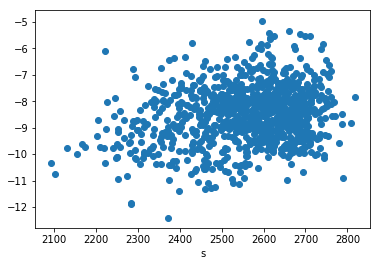

In [16]:
plt.scatter(predictions[:,0],predictions[:,1])
plt.xlabel('s')
plt.xlabel('s')
plt.show()

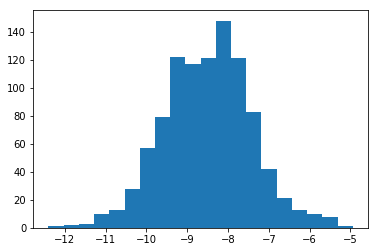

In [17]:

# plt.hist(predictions[:,0],bins=20)
plt.hist(predictions[:,1],bins=20)
# plt.hist(predictions[:,-1],bins=20)
plt.show()

In [18]:
print(y_data[0])

[2712.06453761   -9.20361459   -3.64420375  -13.           -6.33353557]


### Generate Test Data

In [16]:
# x_data_test, y_data_test = load_data_file(data_file='../test/testing_hela.npy', num_features=num_features)

In [19]:
predictions_val = pipeline.trees_predict(np.array(x_data_val)[0,:])

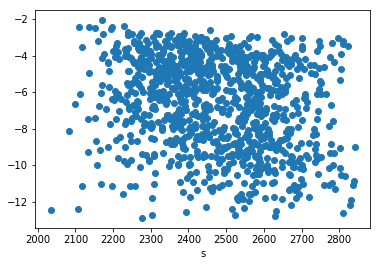

In [20]:
plt.scatter(predictions_val[:,0],predictions_val[:,1])
plt.xlabel('s')
plt.xlabel('s')
plt.show()

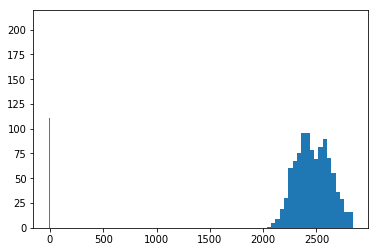

In [22]:
plt.hist(predictions_val[:,0],bins=20)
plt.hist(predictions_val[:,1],bins=20)
plt.hist(predictions_val[:,-1],bins=20)
plt.show()

In [25]:
No_pred = 4000

PRED = np.zeros((No_pred,num_trees,5))
for planet in range(y_data_val.shape[0]):
    PRED[planet] = pipeline.trees_predict(np.array(x_data_val)[planet,:])
# predictions_test = pipeline.trees_predict(np.array(x_data_test)[0,:])

IndexError: index 4000 is out of bounds for axis 0 with size 4000

In [22]:
planet

5207

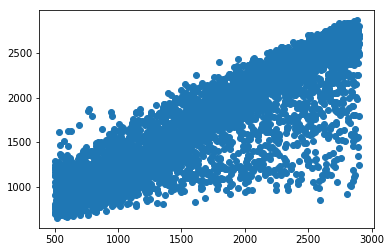

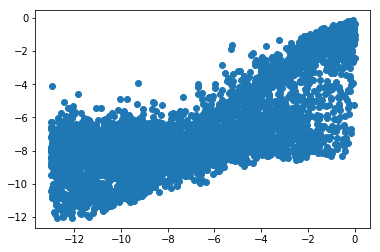

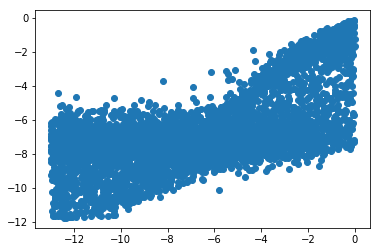

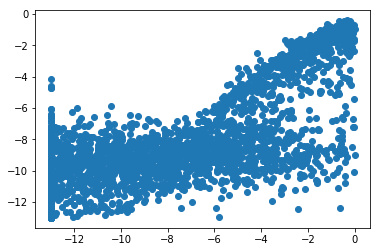

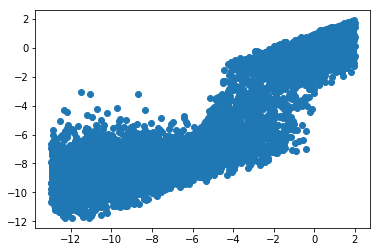

In [23]:
for mol in range(5):
    plt.scatter(y_data_test[:planet,mol],PRED.mean(1)[:planet,mol])
    plt.show()

In [24]:
from itertools import product

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

from sklearn import metrics, neighbors
from sklearn.preprocessing import MinMaxScaler


def predicted_vs_real(y_real, y_pred, names, ranges):
    
    num_plots = y_pred.shape[1]
    num_plot_rows = int(np.sqrt(num_plots))
    num_plot_cols = (num_plots - 1) // num_plot_rows + 1
    
    fig, axes = plt.subplots(num_plot_rows, num_plot_cols,
                             figsize=(5*num_plot_cols, 5*num_plot_rows))
    
    for dim, (ax, name_i, range_i) in enumerate(zip(axes.ravel(), names, ranges)):
        
        current_real = y_real[:, dim]
        current_pred = y_pred[:, dim]
        
        r2 = metrics.r2_score(current_real, current_pred)
        label = "$R^2 = {:.3f}$".format(r2)
        ax.plot(current_real, current_pred, '.', label=label)
        
        ax.plot(range_i, range_i, '--', linewidth=3, color="C3")
        
        ax.axis("equal")
        ax.grid()
        ax.set_xlim(range_i)
        ax.set_ylim(range_i)
        ax.set_xlabel("Real {}".format(name_i), fontsize=18)
        ax.set_ylabel("Predicted {}".format(name_i), fontsize=18)
        ax.legend(loc="upper left", fontsize=14)
    
    fig.tight_layout()
    return fig


def feature_importances(forests, names, colors):
    
    num_plots = len(forests)
    num_plot_rows = (num_plots - 1) // 2 + 1
    num_plot_cols = 2
    
    fig, axes = plt.subplots(num_plot_rows, num_plot_cols,
                             figsize=(15, 3.5*num_plot_rows))
    
    for ax, forest_i, name_i, color_i in zip(axes.ravel(), forests, names, colors):
        ax.bar(np.arange(len(forest_i.feature_importances_)), forest_i.feature_importances_,
               label="Importance for {}".format(name_i),
               width=0.4, color=color_i)
        ax.set_xlabel("Feature index", fontsize=18)
        ax.legend(fontsize=16)
        ax.grid()
    
    fig.tight_layout()
    return fig


def posterior_matrix(estimations, y, names, ranges, colors, soft_colors=None):
    
    cmaps = [LinearSegmentedColormap.from_list("MyReds", [(1, 1, 1), c], N=256)
             for c in colors]
    
    ranges = np.array(ranges)
    
    if soft_colors is None:
        soft_colors = colors
    
    num_dims = estimations.shape[1]
    
    fig, axes = plt.subplots(nrows=num_dims, ncols=num_dims,
                             figsize=(2 * num_dims, 2 * num_dims))
    fig.subplots_adjust(left=0.07, right=1-0.05,
                        bottom=0.07, top=1-0.05,
                        hspace=0.05, wspace=0.05)
    
    for ax, dims in zip(axes.flat, product(range(num_dims), range(num_dims))):
        dims = list(dims[::-1])
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        ax.title.set_visible(False)
        if ax.is_first_col():
            ax.yaxis.set_ticks_position('left')
            ax.yaxis.set_visible(True)
            if names is not None:
                ax.set_ylabel(names[dims[1]], fontsize=18)
        if ax.is_last_col():
            ax.yaxis.set_ticks_position('right')
            ax.yaxis.set_visible(True)
        if ax.is_first_row():
            ax.xaxis.set_ticks_position('top')
            ax.xaxis.set_visible(True)
        if ax.is_last_row():
            ax.xaxis.set_ticks_position('bottom')
            ax.xaxis.set_visible(True)
            if names is not None:
                ax.set_xlabel(names[dims[0]], fontsize=18)
        if ax.is_first_col() and ax.is_first_row():
            ax.yaxis.set_visible(False)
            ax.set_ylabel("")
        if ax.is_last_col() and ax.is_last_row():
            ax.yaxis.set_visible(False)
        
        if dims[0] < dims[1]:
            locations, kd_probs, *_ = _kernel_density_joint(estimations[:, dims], ranges[dims])
            ax.contour(locations[0], locations[1],
                       kd_probs,
                       colors=colors[dims[0]],
                       linewidths=0.5
                       # 'copper', # 'hot', 'magma' ('copper' with white background)
                      )
            histogram, grid_x, grid_y = _histogram(estimations[:, dims], ranges[dims])
            ax.pcolormesh(grid_x, grid_y, histogram, cmap=cmaps[dims[0]])
            
            expected = np.median(estimations[:, dims], axis=0)
            ax.plot([expected[0], expected[0]], [ranges[dims[1]][0], ranges[dims[1]][1]], '-', linewidth=1, color='#222222')
            ax.plot([ranges[dims[0]][0], ranges[dims[0]][1]], [expected[1], expected[1]], '-', linewidth=1, color='#222222')
            ax.plot(expected[0], expected[1], '.', color='#222222')
            ax.axis('normal')
            if y is not None:
                real = y[dims]
                ax.plot(real[0], real[1], '*', markersize=10, color='#FF0000')
            ax.axis([ranges[dims[0]][0], ranges[dims[0]][1],
                     ranges[dims[1]][0], ranges[dims[1]][1]])
        elif dims[0] > dims[1]:
            ax.plot(estimations[:, dims[0]], estimations[:, dims[1]], '.', color=soft_colors[dims[1]])
            ax.axis([ranges[dims[0]][0], ranges[dims[0]][1],
                     ranges[dims[1]][0], ranges[dims[1]][1]])
        else:
            histogram, bins = _histogram(estimations[:, dims[:1]], ranges=ranges[dims[:1]])
            ax.bar(bins[:-1], histogram, color=soft_colors[dims[0]], width=bins[1]-bins[0])
            
            kd_probs = histogram
            expected = np.median(estimations[:, dims[0]])
            ax.plot([expected, expected], [0, 1.1 * kd_probs.max()], '-', linewidth=1, color='#222222')
            
            if y is not None:
                real = y[dims[0]]
                ax.plot([real, real], [0, kd_probs.max()], 'r-')
            ax.axis([ranges[dims[0]][0], ranges[dims[0]][1],
                     0, 1.1 * kd_probs.max()])
    
    # fig.tight_layout(pad=0)
    return fig


def _min_max_scaler(ranges, feature_range=(0, 100)):
    res = MinMaxScaler()
    res.data_max_ = ranges[:, 1]
    res.data_min_ = ranges[:, 0]
    res.data_range_ = res.data_max_ - res.data_min_
    res.scale_ = (feature_range[1] - feature_range[0]) / (ranges[:, 1] - ranges[:, 0])
    res.min_ = -res.scale_ * res.data_min_
    res.n_samples_seen_ = 1
    res.feature_range = feature_range
    return res


def _kernel_density_joint(estimations, ranges, bandwidth=1/25):
    
    ndims = len(ranges)
    
    scaler = _min_max_scaler(ranges, feature_range=(0, 100))
    
    bandwidth = bandwidth * 100
    # step = 1.0
    
    kd = neighbors.KernelDensity(bandwidth=bandwidth).fit(scaler.transform(estimations))
    locations1d = np.arange(0, 100, 1)
    locations = np.reshape(np.meshgrid(*[locations1d] * ndims), (ndims, -1)).T
    kd_probs = np.exp(kd.score_samples(locations))
    
    shape = (ndims,) + (len(locations1d),) * ndims
    locations = scaler.inverse_transform(locations)
    locations = np.reshape(locations.T, shape)
    kd_probs = np.reshape(kd_probs, shape[1:])
    return locations, kd_probs, kd


def _histogram(estimations, ranges, bins=20):
    
    if len(ranges) == 1:
        histogram, edges = np.histogram(estimations[:, 0], bins=bins, range=ranges[0])
        return histogram, edges
    
    if len(ranges) == 2:
        histogram, xedges, yedges = np.histogram2d(estimations[:, 0], estimations[:, 1], bins=bins, range=ranges)
        grid_x, grid_y = np.meshgrid(xedges, yedges)
        return histogram.T, grid_x, grid_y, 

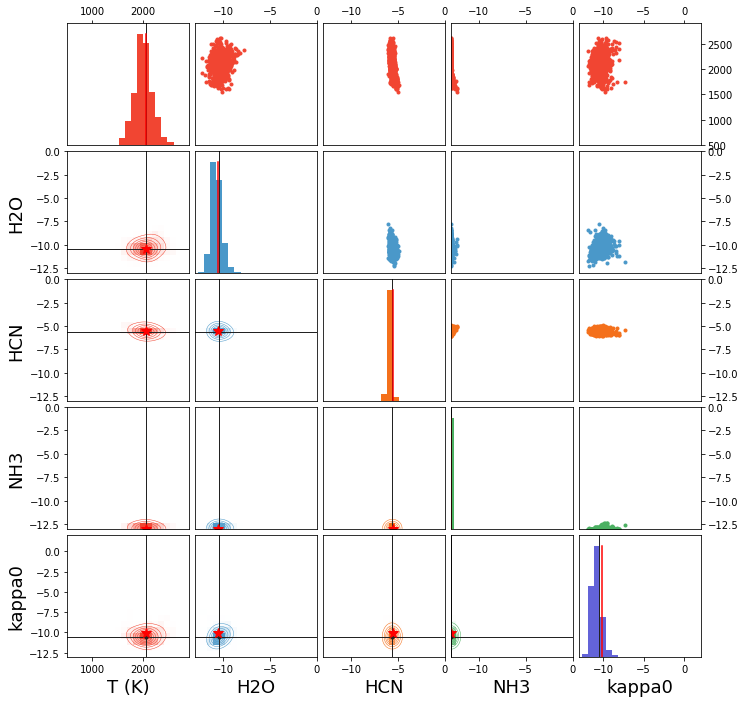

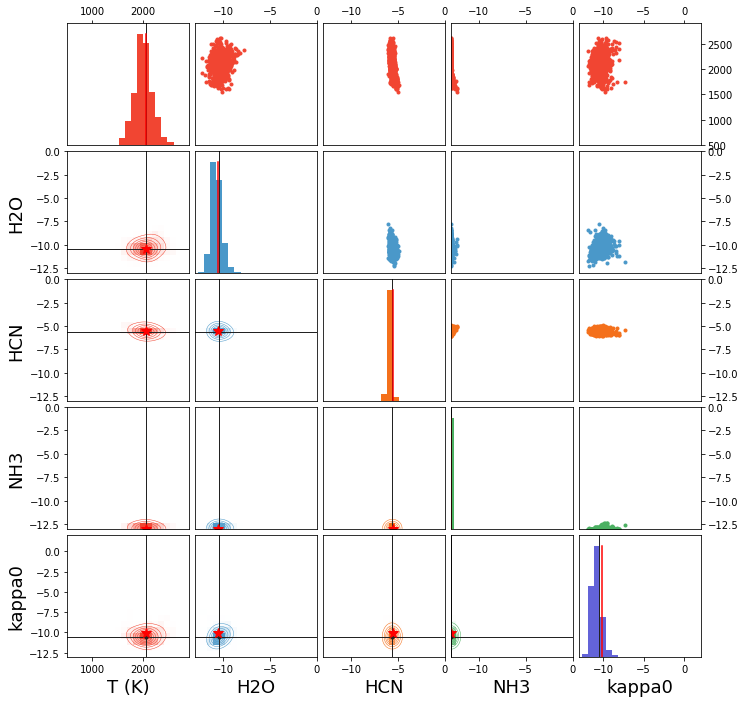

In [28]:
planet_id = 10
num_features = 5
ranges=[[x, y] for x, y in zip(y_data_test.min(0), y_data_test.max(0))]
# [[0, .1],[0, .1],[0, .1],[0, .1],[0, .1],[0, .1],[0, .1],[0, .1],[0, .1],[0, .1],[0, .1],[0, .1],[0, 1],[0, 1]]
names =  ["T (K)", "H2O", "HCN", "NH3", "kappa0"]
colors = ["#F14532", "#4a98c9", "#f4701b", "#4bb062", "#6363d8"]#, "#F14532", "#4a98c9", "#f4701b", 
#           "#4bb062", "#6363d8","#4bb062", "#6363d8","#4a98c9", "#f4701b"]
posterior_matrix(PRED[planet_id,:,:num_features], y_data_test[planet_id,:num_features], names, ranges, colors, soft_colors=None)

In [47]:
np.unique(PRED[planet_id,:, 1])

array([0.03275222, 0.0327566 , 0.03287681, 0.0329064 , 0.03321641,
       0.03325595, 0.0332669 , 0.03333472, 0.03337912, 0.03338786,
       0.03339086, 0.03340498, 0.03343367, 0.03343646, 0.03344366,
       0.03346138, 0.03346383, 0.03346562, 0.03347371, 0.03348421,
       0.03348688, 0.03350122, 0.03350806, 0.03351277, 0.03352424,
       0.03353767, 0.03354675, 0.03355182, 0.03358472, 0.03358899,
       0.03359175, 0.03359562, 0.03359963, 0.03360327, 0.0336067 ,
       0.03360753, 0.03361429, 0.03361472, 0.03361968, 0.0336224 ,
       0.03363265, 0.03363795, 0.03364141, 0.03364602, 0.03364973,
       0.03366085, 0.03367178, 0.03367569, 0.03367772, 0.03368361,
       0.03370344, 0.03371701, 0.03372384, 0.03372515, 0.0337345 ,
       0.03373497, 0.0337364 , 0.03373785, 0.0337456 , 0.03377666,
       0.03377705, 0.0337809 , 0.03378175, 0.03378348, 0.03378515,
       0.03378581, 0.03378944, 0.03378955, 0.03379753, 0.03380089,
       0.03380373, 0.03381112, 0.0338121 , 0.03381604, 0.03381

In [27]:
PRED.shape

(12, 1000, 14)

array([5.00395243e+02, 1.50693056e-01, 7.60040035e-01, 7.60289320e-01,
       7.78909132e-01, 1.49255949e-01, 3.01333131e-02, 3.01751398e-02,
       6.05166579e-03, 2.94155100e-02, 1.59365000e-02, 1.23106612e-03,
       7.19652428e+03, 1.97809917e+00])